In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import optimize
import random
import itertools
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(".."))
from opt_emergency.stat import HalfPointTriangularDist, ExponentialDistApprox

sns.set_style("darkgrid")
# plt.rcParams["font.family"] = "Nanum Gothic"
# mpl.rc("font", family="Nanum Gothic")
plt.rcParams['axes.unicode_minus'] = False

## 삼각분포 근사 알고리즘

/var/folders/zk/35s80sbd2sx1mxbrymjjqqf80000gn/T/ipykernel_74044/3399393580.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


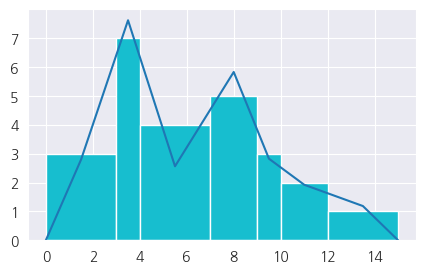

In [5]:
fig, ax = plt.subplots(figsize=(5, 3))
bins_ex = np.array([0, 3, 4, 7, 9, 10, 12, 15])
values_ex = np.array([3, 7, 4, 5, 3, 2, 1])
m = (bins_ex[1:] + bins_ex[:-1]) / 2

hptd = HalfPointTriangularDist(bins_ex, values_ex)
y = hptd.y_values()
ax.plot(np.insert(m, [0, len(m)], [bins_ex[0], bins_ex[-1]]), np.insert(y, [0, len(m)], [0, 0]))
ax.bar(bins_ex[:-1], values_ex, width=np.diff(bins_ex), align="edge", color=sns.color_palette()[9])
fig.show()

/var/folders/zk/35s80sbd2sx1mxbrymjjqqf80000gn/T/ipykernel_74044/2775985017.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


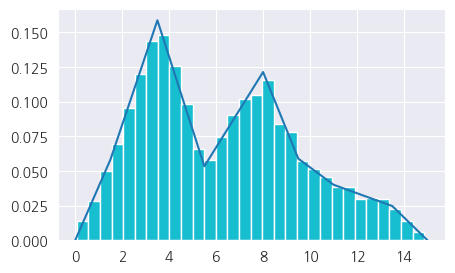

In [6]:
fig, ax = plt.subplots(figsize=(5, 3))

m = (bins_ex[1:] + bins_ex[:-1]) / 2
hptd = HalfPointTriangularDist(bins_ex, values_ex)
y = hptd.y_values()
area = sum(values_ex * np.diff(bins_ex))
ax.plot(np.insert(m, [0, len(m)], [bins_ex[0], bins_ex[-1]]), np.insert(y, [0, len(m)], [0, 0]) / area)  # plot density

rv = hptd.random_values(10000)
ax.hist(rv, bins=30, density=True, color=sns.color_palette()[9])
fig.show()

## 응급실 재실시간 지수분포 근사

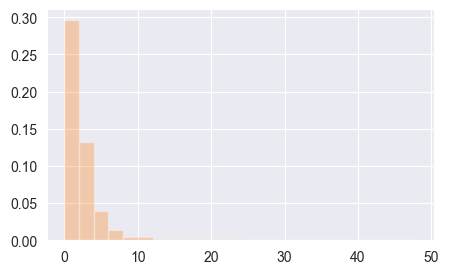

In [2]:
in_room_duration_ratio = np.array([59.2, 26.5, 8.0, 2.8, 1.7, 1.3, 0.6])
bins = np.array([0, 2, 4, 6, 8, 12, 24, 48])

fig, ax = plt.subplots(figsize=(5, 3))
# ax.hist(np.random.exponential(2.2, 10000), bins=bins, density=True, alpha=0.3)
ax.bar(bins[:-1], in_room_duration_ratio / np.diff(bins) / 100, width=np.diff(bins), align="edge", color=sns.color_palette()[1], alpha=0.3)
# ax.set_yscale("log")
plt.show()

2.6003996003996006


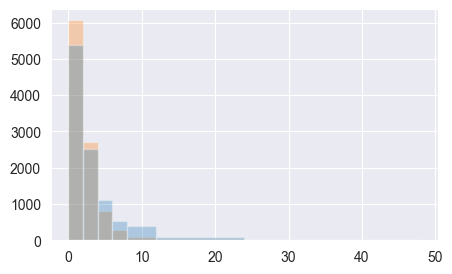

In [3]:
m = (bins[1:] + bins[:-1]) / 2
avg_time = sum([x * dur for x, dur in zip(m, in_room_duration_ratio)]) / sum(in_room_duration_ratio)
print(avg_time)
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(bins[:-1], in_room_duration_ratio / np.diff(bins) / sum(in_room_duration_ratio / np.diff(bins)) * 10000, width=np.diff(bins), align="edge", color=sns.color_palette()[1], alpha=0.3)
ax.hist(np.random.exponential(avg_time, 10000), bins=bins, alpha=0.3)
plt.show()

0.4255555659674911 2.3498693942036035


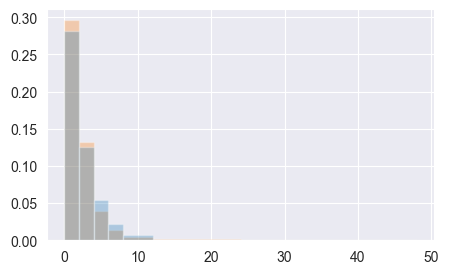

In [14]:
fig, ax = plt.subplots(figsize=(5, 3))
eda = ExponentialDistApprox(bins, values=in_room_duration_ratio / np.diff(bins))
lam = eda.find_lambda()
print(lam, 1 / lam)
ax.bar(bins[:-1], in_room_duration_ratio / np.diff(bins) / 100, width=np.diff(bins), align="edge", color=sns.color_palette()[1], alpha=0.3)
ax.hist(np.random.exponential(1 / lam, 10000), bins=bins, density=True, alpha=0.3)
# ax.set_yscale("log")
plt.show()

## 몬테카를로: 예상 대기시간

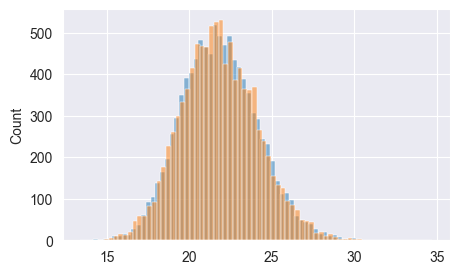

(np.float64(89.33361282359937), np.float64(0.24444837459937963))

In [122]:
def simulate_waiting_time(sickbed_cnt, patient_cnt, lam):
    treatment_times = np.random.exponential(1 / lam, patient_cnt).tolist()
    bed_times = np.zeros(sickbed_cnt)
    while treatment_times:
        min_bed_index = np.argmin(bed_times)
        bed_times[min_bed_index] += treatment_times.pop()
        # print(bed_times)
    return np.min(bed_times)  # 대기열에 새로 추가된 환자가 진료 시작하는 시간이므로 minimum value

def monte_carlo_waiting_time(sickbed_cnt, patient_cnt, lam, iter_, plot=False):
    waiting_times = list()
    for _ in range(iter_):
        waiting_times.append(simulate_waiting_time(sickbed_cnt, patient_cnt, lam))
    avg = np.mean(waiting_times)
    std = np.std(waiting_times)
    alpha = avg ** 2 / std ** 2
    beta = std ** 2 / avg
    
    if plot:
        plt.figure(figsize=(5, 3))
        sns.histplot(waiting_times, alpha=0.5)
        sns.histplot(np.random.gamma(alpha, beta, 10000), alpha=0.5)
        plt.show()

    return alpha, beta

monte_carlo_waiting_time(10, 100, 1/2.4, 10000, plot=True)

  0%|          | 0/10 [00:00<?, ?it/s]

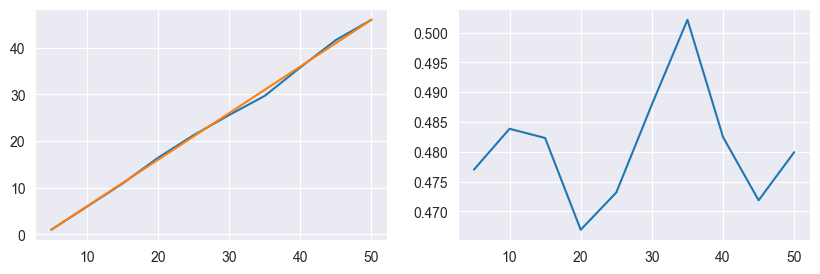

In [147]:
# 감마분포 가정 -> alpha, beta 찾기
sickbed_cnt = 5
patient_cnt_grid = np.arange(5, 51, 5)
alpha_list = list()
beta_list = list()
for patient_cnt in tqdm(patient_cnt_grid):
    alpha, beta = monte_carlo_waiting_time(sickbed_cnt, patient_cnt, lam=1/2.4, iter_=10000)
    alpha_list.append(alpha)
    beta_list.append(beta)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(patient_cnt_grid, alpha_list)
axes[0].plot(patient_cnt_grid, [p - sickbed_cnt + 1 for p in patient_cnt_grid])
axes[1].plot(patient_cnt_grid, beta_list)
plt.show()
# alpha = 환자수 - 병상수 + 1, beta는 환자수 무관

  0%|          | 0/10 [00:00<?, ?it/s]

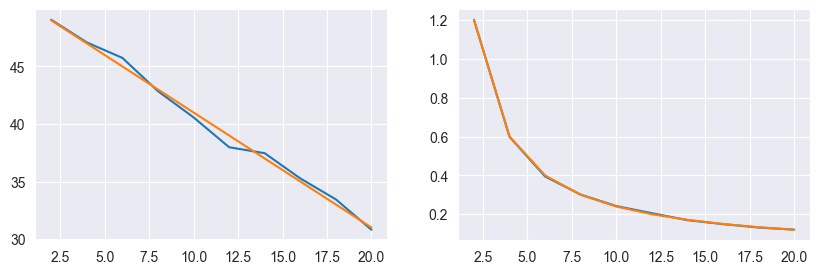

In [149]:
sickbed_cnt_grid = np.arange(2, 21, 2)
patient_cnt = 50
alpha_list = list()
beta_list = list()
for sickbed_cnt in tqdm(sickbed_cnt_grid):
    alpha, beta = monte_carlo_waiting_time(sickbed_cnt, patient_cnt, lam=1/2.4, iter_=10000)
    alpha_list.append(alpha)
    beta_list.append(beta)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(sickbed_cnt_grid, alpha_list)
axes[0].plot(sickbed_cnt_grid, [patient_cnt - s + 1 for s in sickbed_cnt_grid])
axes[1].plot(sickbed_cnt_grid, beta_list)
axes[1].plot(sickbed_cnt_grid, [2.4/x for x in sickbed_cnt_grid])
plt.show()
# alpha = 환자수 - 병상수 + 1, beta = 1 / (lambda * 병상 수)

## 응급실 재실시간 vs ktas 분포 연구

In [11]:
ktas_level_ratio = [1.2, 4.1, 43.0, 41.8, 9.6]

np.random.poisson()

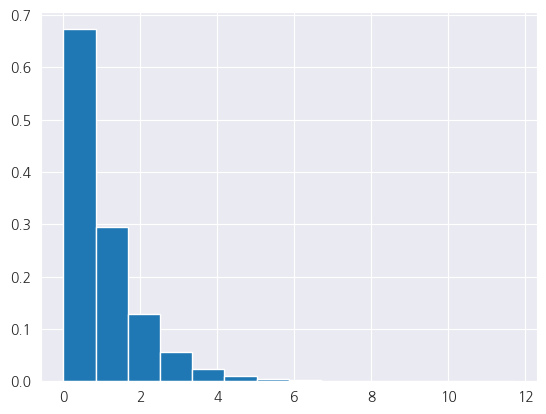

In [32]:
lam = 1
plt.hist(np.random.exponential(lam, 10000), 14, density=True)
plt.show()